## Load Data and Visulization


In [3]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset, DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import functional as F

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import os
import zipfile
import shutil
import random
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import timm
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
from collections import defaultdict
import matplotlib.pyplot as plt
import copy

In [4]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [15]:
zip_path = "dataset_team60.zip"
extract_path = "datasets"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [16]:
def remove_invalid_dirs(base_path):
    """
    Remove all .ipynb_checkpoints directories from the dataset.
    Args:
        base_path: Root path of the dataset.
    """
    for root, dirs, files in os.walk(base_path):
        for d in dirs:
            if d == ".ipynb_checkpoints":
                dir_path = os.path.join(root, d)
                shutil.rmtree(dir_path)
                print(f"Removed: {dir_path}")

In [17]:
def preprocess_dataset(dataset_name, dataset_path, output_path, split_ratio=0.8):
    """
    Adjust the structure of FER-2013, MMAFEDB, and Affectnet datasets.
    Args:
        dataset_name: Name of the dataset (FER-2013, MMAFEDB, Affectnet).
        dataset_path: Path to the original dataset.
        output_path: Path to save the processed dataset.
        split_ratio: Proportion of data to allocate to the train set.
    """
    os.makedirs(output_path, exist_ok=True)
    train_dir = os.path.join(output_path, "train")
    test_dir = os.path.join(output_path, "test")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    if dataset_name == "FER-2013":
        # Directly copy existing train/test structure
        shutil.copytree(os.path.join(dataset_path, "train"), train_dir, dirs_exist_ok=True)
        shutil.copytree(os.path.join(dataset_path, "test"), test_dir, dirs_exist_ok=True)

    elif dataset_name == "MMAFEDB":
        # Copy train and test folders
        shutil.copytree(os.path.join(dataset_path, "train"), train_dir, dirs_exist_ok=True)
        shutil.copytree(os.path.join(dataset_path, "test"), test_dir, dirs_exist_ok=True)

        # Merge 'valid' into 'train'
        valid_path = os.path.join(dataset_path, "valid")
        if os.path.exists(valid_path):
            for class_name in os.listdir(valid_path):
                class_dir = os.path.join(valid_path, class_name)
                if os.path.isdir(class_dir):
                    target_class_dir = os.path.join(train_dir, class_name)
                    os.makedirs(target_class_dir, exist_ok=True)
                    for img in os.listdir(class_dir):
                        if img.lower().endswith(('.jpg', '.png')):
                            shutil.copy(os.path.join(class_dir, img), target_class_dir)

    elif dataset_name == "Affectnet":
        # Split AffectNet into train/test
        for class_name in os.listdir(dataset_path):
            class_dir = os.path.join(dataset_path, class_name)
            if not os.path.isdir(class_dir):
                continue  # Skip non-folder files

            target_train_dir = os.path.join(train_dir, class_name)
            target_test_dir = os.path.join(test_dir, class_name)
            os.makedirs(target_train_dir, exist_ok=True)
            os.makedirs(target_test_dir, exist_ok=True)

            # Shuffle and split data
            images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.png'))]
            random.shuffle(images)
            split_idx = int(len(images) * split_ratio)
            for i, img in enumerate(images):
                src_path = os.path.join(class_dir, img)
                if i < split_idx:
                    shutil.copy(src_path, os.path.join(target_train_dir, img))
                else:
                    shutil.copy(src_path, os.path.join(target_test_dir, img))


In [18]:
# Preprocess each dataset
datasets = {
    "FER-2013": "datasets/FER-2013",
    "MMAFEDB": "datasets/MMAFEDB",
    "Affectnet": "datasets/Affectnet"
}

output_base_path = "processed_dataset"

# Process each dataset
for name, path in datasets.items():
    print(f"Cleaning {name}...")
    remove_invalid_dirs(path)  # Remove .ipynb_checkpoints
    print(f"Processing {name}...")
    preprocess_dataset(name, path, os.path.join(output_base_path, name))
    print(f"{name} processing complete!")

print("\nAll datasets processed successfully!")

Cleaning FER-2013...
Processing FER-2013...
FER-2013 processing complete!
Cleaning MMAFEDB...
Processing MMAFEDB...
MMAFEDB processing complete!
Cleaning Affectnet...
Processing Affectnet...
Affectnet processing complete!

All datasets processed successfully!


In [19]:
from collections import defaultdict

def check_dataset_stats(dataset_path):
    """
    Check the number of images, shape, and color mode (RGB/greyscale) in the dataset.
    Args:
        dataset_path: Path to the processed dataset (e.g., 'processed_dataset/FER-2013').
    Returns:
        A dictionary with class counts for train and test splits.
    """
    stats = {}
    total_images = {"train": 0, "test": 0}
    class_counts = {"train": defaultdict(int), "test": defaultdict(int)}  # To store counts per class

    for split in ['train', 'test']:
        split_path = os.path.join(dataset_path, split)
        if not os.path.exists(split_path):
            print(f"{split} folder not found in {dataset_path}")
            continue

        class_stats = {}
        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)

            # Exclude invalid directories (e.g., .ipynb_checkpoints)
            if not os.path.isdir(class_path) or class_name.startswith('.'):
                continue

            image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png'))]
            num_images = len(image_files)
            total_images[split] += num_images
            class_counts[split][class_name] += num_images  # Accumulate class counts

            # Get the shape and mode of the first image
            if num_images > 0:
                sample_image_path = os.path.join(class_path, image_files[0])
                with Image.open(sample_image_path) as img:
                    shape = img.size  # (width, height)
                    mode = img.mode  # RGB or L (greyscale)
            else:
                shape = None
                mode = None

            class_stats[class_name] = {
                'num_images': num_images,
                'sample_image_shape': shape,
                'color_mode': mode
            }

        stats[split] = class_stats

    # Print dataset stats
    for split, split_stats in stats.items():
        print(f"\n{split.upper()} stats for {os.path.basename(dataset_path)}:")
        for class_name, class_data in split_stats.items():
            print(f"  Class '{class_name}': {class_data['num_images']} images, "
                  f"Sample shape: {class_data['sample_image_shape']}, "
                  f"Color mode: {class_data['color_mode']}")
        print(f"  Total images in {split}: {total_images[split]}")

    return class_counts

In [20]:
# Process each dataset and accumulate class counts
output_base_path = "processed_dataset"
all_class_counts = {"train": defaultdict(int), "test": defaultdict(int)}

for dataset_name in datasets.keys():
    dataset_path = os.path.join(output_base_path, dataset_name)
    print(f"\nChecking stats for {dataset_name}...")
    class_counts = check_dataset_stats(dataset_path)

    # Combine class counts from all datasets
    for split in ['train', 'test']:
        for class_name, count in class_counts[split].items():
            all_class_counts[split][class_name] += count

# Print combined class counts
print("\nCombined Class Counts (Train):", dict(all_class_counts["train"]))
print("Combined Class Counts (Test):", dict(all_class_counts["test"]))


Checking stats for FER-2013...

TRAIN stats for FER-2013:
  Class 'disgust': 436 images, Sample shape: (48, 48), Color mode: L
  Class 'angry': 3995 images, Sample shape: (48, 48), Color mode: L
  Class 'happy': 7215 images, Sample shape: (48, 48), Color mode: L
  Class 'neutral': 4965 images, Sample shape: (48, 48), Color mode: L
  Class 'surprise': 3171 images, Sample shape: (48, 48), Color mode: L
  Class 'sad': 4830 images, Sample shape: (48, 48), Color mode: L
  Class 'fear': 4097 images, Sample shape: (48, 48), Color mode: L
  Total images in train: 28709

TEST stats for FER-2013:
  Class 'disgust': 111 images, Sample shape: (48, 48), Color mode: L
  Class 'angry': 958 images, Sample shape: (48, 48), Color mode: L
  Class 'happy': 1774 images, Sample shape: (48, 48), Color mode: L
  Class 'neutral': 1233 images, Sample shape: (48, 48), Color mode: L
  Class 'surprise': 831 images, Sample shape: (48, 48), Color mode: L
  Class 'sad': 1247 images, Sample shape: (48, 48), Color mod

In [21]:
from torchvision.transforms import functional as F
from torchvision.transforms import (
    Resize, RandomRotation, RandomHorizontalFlip, ToTensor, Normalize, RandomAdjustSharpness
)

# Custom transformation to handle grayscale and RGB images
class ConvertToRGB:
    def __call__(self, img):
        if img.mode == 'L':  # Check if the image is grayscale (mode 'L')
            return img.convert('RGB')  # Convert grayscale to RGB
        return img  # If already RGB, return as is

image_mean = [0.5, 0.5, 0.5]  # Typical mean used by many pretrained models
image_std = [0.5, 0.5, 0.5]   # Typical std used by many pretrained models
size = 224

normalize = Normalize(mean=image_mean, std=image_std)

# Standardization (resize to 224x224)
standard_transform = transforms.Compose([
    ConvertToRGB(),                      # Conditionally convert to RGB
    transforms.Resize((224, 224)),       # Resize to 224x224
])

# Augmentation
augmentation_transform = transforms.Compose([
    RandomRotation(90),
    RandomAdjustSharpness(2),
    RandomHorizontalFlip(0.5),
])

# Normalization
normalization_transform = transforms.Compose([
    ToTensor(),
    normalize,
])

# Final train transform
train_transform = transforms.Compose([
    standard_transform,    # Standardization
    augmentation_transform, # Augmentation
    normalization_transform # Normalization
])

# Final test transform (no augmentation)
test_transform = transforms.Compose([
    standard_transform,
    ToTensor(),
    normalize
])

In [22]:
# Load datasets
fer_train = ImageFolder(root="processed_dataset/FER-2013/train", transform=train_transform)
fer_test = ImageFolder(root="processed_dataset/FER-2013/test", transform=test_transform)

mma_train = ImageFolder(root="processed_dataset/MMAFEDB/train", transform=train_transform)
mma_test = ImageFolder(root="processed_dataset/MMAFEDB/test", transform=test_transform)

affect_train = ImageFolder(root="processed_dataset/Affectnet/train", transform=train_transform)
affect_test = ImageFolder(root="processed_dataset/Affectnet/test", transform=test_transform)

# Combine datasets
combined_train_data = ConcatDataset([fer_train, mma_train, affect_train])
combined_test_data = ConcatDataset([fer_test, mma_test, affect_test])

In [23]:
def check_combined_dataset_stats(dataset, dataset_name):
    """
    Check statistics of the combined dataset (train/test).
    Args:
        dataset: The combined PyTorch dataset.
        dataset_name: Name of the dataset ('train' or 'test').
    """
    num_images = len(dataset)
    print(f"\n{dataset_name.upper()} Combined Dataset:")
    print(f"  Total number of images: {num_images}")

    # Check a single sample for shape and color mode
    loader = DataLoader(dataset, batch_size=1, shuffle=True)
    sample, _ = next(iter(loader))
    shape = tuple(sample.shape)  # (channels, height, width)
    print(f"  Sample image shape: {shape}")
    print(f"  Color mode: {'Grayscale' if shape[0] == 1 else 'RGB'}")

In [25]:
# Check combined dataset stats
check_combined_dataset_stats(combined_train_data, "train")
check_combined_dataset_stats(combined_test_data, "test")


TRAIN Combined Dataset:
  Total number of images: 164157
  Sample image shape: (1, 3, 224, 224)
  Color mode: Grayscale

TEST Combined Dataset:
  Total number of images: 33963
  Sample image shape: (1, 3, 224, 224)
  Color mode: Grayscale


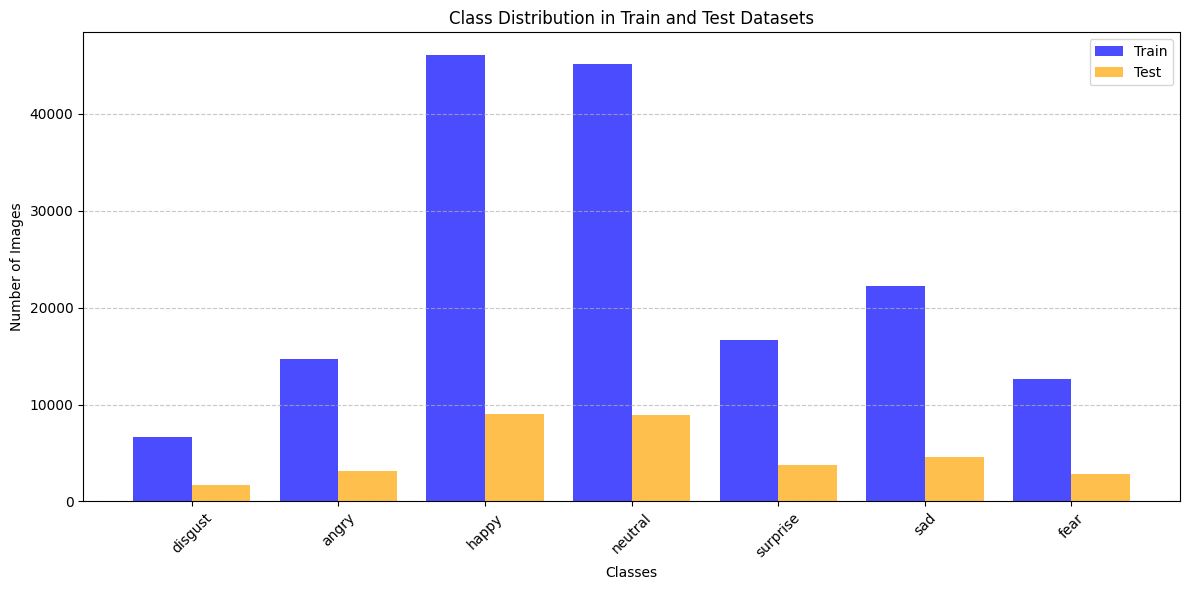

In [26]:
import matplotlib.pyplot as plt
def plot_combined_counts_side_by_side(train_counts, test_counts):
    # Convert defaultdicts to regular dictionaries if needed
    train_counts = dict(train_counts)
    test_counts = dict(test_counts)

    # Ensure classes are in the same order for both train and test datasets
    classes = list(train_counts.keys())
    train_values = [train_counts[cls] for cls in classes]
    test_values = [test_counts[cls] for cls in classes]

    # Define bar positions
    x = np.arange(len(classes))  # Class indices
    width = 0.4  # Bar width

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, train_values, width, label="Train", color="blue", alpha=0.7)
    plt.bar(x + width/2, test_values, width, label="Test", color="orange", alpha=0.7)

    # Add labels, title, and legend
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.title("Class Distribution in Train and Test Datasets")
    plt.xticks(x, classes, rotation=45)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Plot the side-by-side bar charts
plot_combined_counts_side_by_side(all_class_counts["train"], all_class_counts["test"])

In [27]:
# number of subprocesses to use for data loading
num_workers = 4
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2

In [28]:
# obtain training indices that will be used for validation
num_train = len(combined_train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [29]:
# Define samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [30]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(combined_train_data, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(combined_train_data, batch_size=batch_size,
                                           sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(combined_test_data, batch_size=batch_size,
                                          num_workers=num_workers)

In [31]:
def check_dataset_classes(dataset, dataset_name):
    """
    Check the class information for a specific dataset.
    Args:
        dataset: The dataset to check (e.g., fer_train, mma_train, affect_train).
        dataset_name: The name of the dataset (e.g., "FER2013").
    """
    classes = dataset.classes  # Class names
    num_classes = len(classes)  # Number of classes
    print(f"\n{dataset_name} Dataset:")
    print(f"  Number of classes: {num_classes}")
    print(f"  Classes: {classes}")
    return classes

# Check classes for each dataset
fer_classes = check_dataset_classes(fer_train, "FER2013")
mma_classes = check_dataset_classes(mma_train, "MMAFEDB")
affect_classes = check_dataset_classes(affect_train, "AffectNet")

# Ensure all datasets share the same class structure
if fer_classes == mma_classes == affect_classes:
    print("\nAll datasets have consistent class structures. Ready to proceed!")
else:
    print("\nWarning: Datasets have inconsistent class structures. Please investigate!")


FER2013 Dataset:
  Number of classes: 7
  Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

MMAFEDB Dataset:
  Number of classes: 7
  Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

AffectNet Dataset:
  Number of classes: 7
  Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

All datasets have consistent class structures. Ready to proceed!


In [32]:
import matplotlib.pyplot as plt
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    if img.shape[0] == 1:  # If the image has 1 channel, it's grayscale
        plt.imshow(img[0], cmap="gray")  # Use grayscale colormap
    else:  # If the image has 3 channels, it's RGB
        plt.imshow(np.transpose(img, (1, 2, 0)))  # Convert to HWC format for RGB display

In [33]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
images.shape

(32, 3, 224, 224)

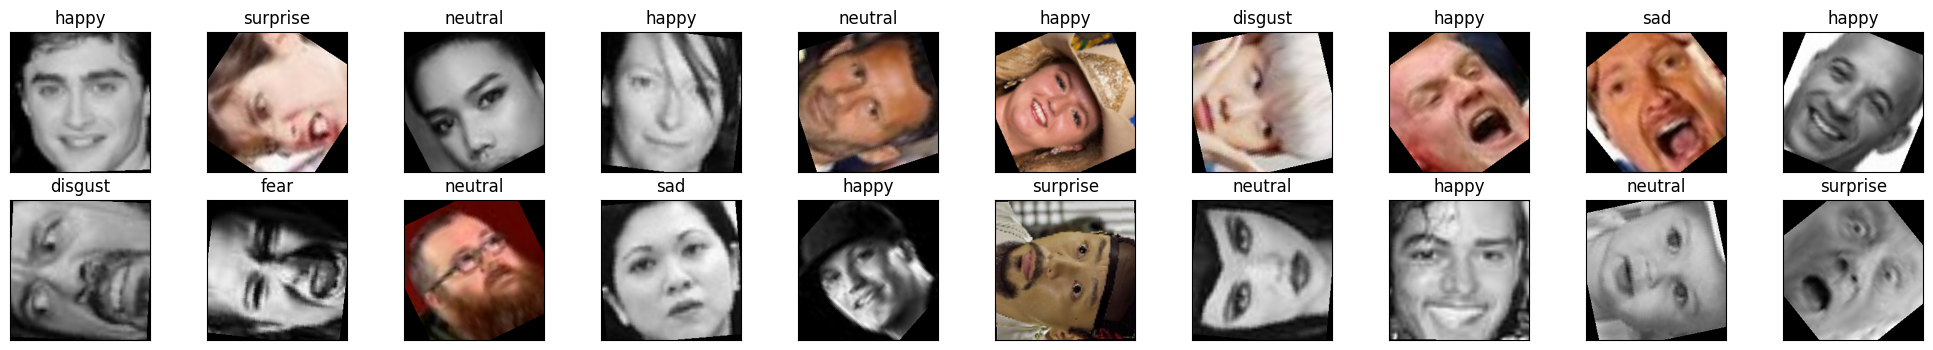

In [34]:
# plot 20 images, along with the corresponding labels
classes = fer_classes
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Model

In [35]:
# Load pretrained ViT model from timm
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Modify the classifier to match the number of classes
num_classes = len(all_class_counts["train"])  # Number of output classes
model.head = nn.Linear(model.head.in_features, num_classes)

print(model)  # View model architecture

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [36]:
import math

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Hyperparameters
learning_rate = 3e-5
weight_decay = 0.1
num_epochs = 5  # Number of epochs
gradient_accumulation_steps = 8  # Accumulating gradients for larger effective batch size
warmup_steps = 1000  # Gradual learning rate increase
eval_steps = 200  # Evaluate every 100 steps
logging_steps = 50  # Log every 50 steps
per_device_train_batch_size = batch_size  # Batch size

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Total steps = (number of batches per epoch * num_epochs) / gradient_accumulation_steps
total_update_steps = (len(train_loader) * num_epochs) // gradient_accumulation_steps

def lr_lambda(current_step: int):
    if current_step < warmup_steps:
        # Linear warmup
        return float(current_step) / float(max(1, warmup_steps))
    # After warmup, apply cosine decay from warmup_steps to total_update_steps
    progress = (current_step - warmup_steps) / float(max(1, total_update_steps - warmup_steps))
    return 0.5 * (1.0 + math.cos(math.pi * progress))

# LambdaLR to incorporate warmup + cosine decay
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

scaler = GradScaler()  # For mixed precision training

<ipython-input-36-e2a2373a3c40>:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision training


In [ ]:
# Lists to store metrics
train_losses = []          # Store average training loss per epoch
valid_losses = []          # Store average validation loss per epoch
valid_accuracies = []      # Store validation accuracy per epoch
steps = []                 # Store steps for plotting

# Manual training loop
global_step = 0
best_accuracy = 0.0
best_model_weights = copy.deepcopy(model.state_dict())  # Keep track of best weights

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()

    # Training phase with progress bar
    progress_bar = tqdm(enumerate(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", total=len(train_loader))
    for step, (inputs, labels) in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Mixed precision forward pass
        with torch.autocast(device_type='cuda', dtype=torch.float16):  # Use updated autocast syntax
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Gradient accumulation
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()
        running_loss += loss.item()

        # Perform optimizer step every `gradient_accumulation_steps`
        if (step + 1) % gradient_accumulation_steps == 0 or (step + 1) == len(train_loader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()

        # Update progress bar at each step
        if global_step % logging_steps == 0:
            avg_loss = running_loss / (step + 1)
            progress_bar.set_postfix({
                "Global Step": global_step,
                "Training Loss": f"{avg_loss:.4f}",
            })

        # Validation at eval_steps
        if global_step % eval_steps == 0 and global_step > 0:
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for val_inputs, val_labels in valid_loader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    val_outputs = model(val_inputs)
                    val_loss += criterion(val_outputs, val_labels).item()
                    _, val_preds = torch.max(val_outputs, 1)
                    total += val_labels.size(0)
                    correct += (val_preds == val_labels).sum().item()

            # Calculate metrics
            accuracy = 100 * correct / total
            avg_val_loss = val_loss / len(valid_loader)

            # Print validation metrics
            print(f"Step {global_step}: Validation Loss = {avg_val_loss:.4f}, Validation Accuracy = {accuracy:.2f}%")

            # Append metrics to lists
            valid_losses.append(avg_val_loss)
            valid_accuracies.append(accuracy)
            steps.append(global_step)

            # Check if this is the best model so far
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_weights = copy.deepcopy(model.state_dict())
                print(f"New best model found at step {global_step} with accuracy {best_accuracy:.2f}%")

            model.train()  # Return to training mode

        global_step += 1

    # Store average training loss for the epoch
    train_losses.append(running_loss / len(train_loader))

# After all epochs, load the best model weights
model.load_state_dict(best_model_weights)
print(f"Training complete. Best validation accuracy: {best_accuracy:.2f}%")

# Save the model
torch.save(model.state_dict(), "trained_vit_model_1209.pt")

Epoch 1/5:   5%|▍         | 204/4104 [01:33<8:16:38,  7.64s/it, Global Step=200, Training Loss=0.2487] 

Step 200: Validation Loss = 1.9018, Validation Accuracy = 24.28%
New best model found at step 200 with accuracy 24.28%


Epoch 1/5:  10%|▉         | 404/4104 [03:04<8:20:56,  8.12s/it, Global Step=400, Training Loss=0.2388] 

Step 400: Validation Loss = 1.7590, Validation Accuracy = 32.97%
New best model found at step 400 with accuracy 32.97%


Epoch 1/5:  15%|█▍        | 603/4104 [04:35<7:56:30,  8.17s/it, Global Step=600, Training Loss=0.2301] 

Step 600: Validation Loss = 1.6277, Validation Accuracy = 38.70%
New best model found at step 600 with accuracy 38.70%


Epoch 1/5:  20%|█▉        | 804/4104 [06:06<5:46:30,  6.30s/it, Global Step=800, Training Loss=0.2213]

Step 800: Validation Loss = 1.4760, Validation Accuracy = 46.56%
New best model found at step 800 with accuracy 46.56%


Epoch 1/5:  24%|██▍       | 1003/4104 [07:37<6:50:16,  7.94s/it, Global Step=1000, Training Loss=0.2114]

Step 1000: Validation Loss = 1.2995, Validation Accuracy = 53.04%
New best model found at step 1000 with accuracy 53.04%


Epoch 1/5:  29%|██▉       | 1204/4104 [09:09<4:59:07,  6.19s/it, Global Step=1200, Training Loss=0.2024]

Step 1200: Validation Loss = 1.2067, Validation Accuracy = 55.87%
New best model found at step 1200 with accuracy 55.87%


Epoch 1/5:  34%|███▍      | 1404/4104 [10:40<5:20:47,  7.13s/it, Global Step=1400, Training Loss=0.1946]

Step 1400: Validation Loss = 1.1343, Validation Accuracy = 58.93%
New best model found at step 1400 with accuracy 58.93%


Epoch 1/5:  39%|███▉      | 1603/4104 [12:11<5:57:09,  8.57s/it, Global Step=1600, Training Loss=0.1873]

Step 1600: Validation Loss = 1.0877, Validation Accuracy = 60.25%
New best model found at step 1600 with accuracy 60.25%


Epoch 1/5:  44%|████▍     | 1804/4104 [13:43<4:17:28,  6.72s/it, Global Step=1800, Training Loss=0.1814]

Step 1800: Validation Loss = 1.0643, Validation Accuracy = 61.06%
New best model found at step 1800 with accuracy 61.06%


Epoch 1/5:  49%|████▉     | 2003/4104 [15:14<4:44:47,  8.13s/it, Global Step=2000, Training Loss=0.1763]

Step 2000: Validation Loss = 1.0416, Validation Accuracy = 61.60%
New best model found at step 2000 with accuracy 61.60%


Epoch 1/5:  54%|█████▎    | 2204/4104 [16:45<3:02:30,  5.76s/it, Global Step=2200, Training Loss=0.1719]

Step 2200: Validation Loss = 1.0280, Validation Accuracy = 61.97%
New best model found at step 2200 with accuracy 61.97%


Epoch 1/5:  59%|█████▊    | 2404/4104 [18:16<3:04:51,  6.52s/it, Global Step=2400, Training Loss=0.1681]

Step 2400: Validation Loss = 0.9994, Validation Accuracy = 63.29%
New best model found at step 2400 with accuracy 63.29%


Epoch 1/5:  63%|██████▎   | 2604/4104 [19:47<2:23:20,  5.73s/it, Global Step=2600, Training Loss=0.1647]

Step 2600: Validation Loss = 1.0005, Validation Accuracy = 63.79%
New best model found at step 2600 with accuracy 63.79%


Epoch 1/5:  68%|██████▊   | 2803/4104 [21:19<2:21:23,  6.52s/it, Global Step=2800, Training Loss=0.1615]

Step 2800: Validation Loss = 1.0060, Validation Accuracy = 63.42%


Epoch 1/5:  73%|███████▎  | 3004/4104 [22:51<2:08:36,  7.02s/it, Global Step=3000, Training Loss=0.1589]

Step 3000: Validation Loss = 0.9596, Validation Accuracy = 64.96%
New best model found at step 3000 with accuracy 64.96%


Epoch 1/5:  78%|███████▊  | 3204/4104 [24:22<1:56:04,  7.74s/it, Global Step=3200, Training Loss=0.1566]

Step 3200: Validation Loss = 0.9578, Validation Accuracy = 65.37%
New best model found at step 3200 with accuracy 65.37%


Epoch 1/5:  83%|████████▎ | 3403/4104 [25:53<1:36:30,  8.26s/it, Global Step=3400, Training Loss=0.1544]

Step 3400: Validation Loss = 0.9455, Validation Accuracy = 65.47%
New best model found at step 3400 with accuracy 65.47%


Epoch 1/5:  88%|████████▊ | 3604/4104 [27:25<49:27,  5.93s/it, Global Step=3600, Training Loss=0.1522]  

Step 3600: Validation Loss = 0.9302, Validation Accuracy = 66.39%
New best model found at step 3600 with accuracy 66.39%


Epoch 1/5:  93%|█████████▎| 3803/4104 [28:56<41:35,  8.29s/it, Global Step=3800, Training Loss=0.1503]

Step 3800: Validation Loss = 0.9331, Validation Accuracy = 66.27%


Epoch 1/5:  98%|█████████▊| 4004/4104 [30:27<10:11,  6.12s/it, Global Step=4000, Training Loss=0.1486]

Step 4000: Validation Loss = 0.9288, Validation Accuracy = 66.32%


Epoch 2/5:   2%|▏         | 100/4104 [01:26<6:50:53,  6.16s/it, Global Step=4200, Training Loss=0.1125]

Step 4200: Validation Loss = 0.9306, Validation Accuracy = 65.91%


Epoch 2/5:   7%|▋         | 300/4104 [02:57<7:08:27,  6.76s/it, Global Step=4400, Training Loss=0.1126] 

Step 4400: Validation Loss = 0.8947, Validation Accuracy = 67.55%
New best model found at step 4400 with accuracy 67.55%


Epoch 2/5:  12%|█▏        | 499/4104 [04:28<8:25:12,  8.41s/it, Global Step=4600, Training Loss=0.1116] 

Step 4600: Validation Loss = 0.9310, Validation Accuracy = 65.99%


Epoch 2/5:  17%|█▋        | 700/4104 [06:00<7:04:40,  7.49s/it, Global Step=4800, Training Loss=0.1114] 

Step 4800: Validation Loss = 0.8826, Validation Accuracy = 68.24%
New best model found at step 4800 with accuracy 68.24%


Epoch 2/5:  22%|██▏       | 900/4104 [07:31<6:26:31,  7.24s/it, Global Step=5000, Training Loss=0.1108] 

Step 5000: Validation Loss = 0.8871, Validation Accuracy = 68.33%
New best model found at step 5000 with accuracy 68.33%


Epoch 2/5:  27%|██▋       | 1099/4104 [09:03<5:36:50,  6.73s/it, Global Step=5200, Training Loss=0.1104]

Step 5200: Validation Loss = 0.8965, Validation Accuracy = 67.16%


Epoch 2/5:  32%|███▏      | 1299/4104 [10:34<7:11:13,  9.22s/it, Global Step=5400, Training Loss=0.1106] 

Step 5400: Validation Loss = 0.8938, Validation Accuracy = 67.33%


Epoch 2/5:  37%|███▋      | 1499/4104 [12:06<6:04:06,  8.39s/it, Global Step=5600, Training Loss=0.1104]

Step 5600: Validation Loss = 0.8762, Validation Accuracy = 68.18%


Epoch 2/5:  41%|████▏     | 1699/4104 [13:38<5:05:29,  7.62s/it, Global Step=5800, Training Loss=0.1103]

Step 5800: Validation Loss = 0.8697, Validation Accuracy = 68.48%
New best model found at step 5800 with accuracy 68.48%


Epoch 2/5:  46%|████▋     | 1899/4104 [15:09<4:52:15,  7.95s/it, Global Step=6000, Training Loss=0.1101]

Step 6000: Validation Loss = 0.8784, Validation Accuracy = 68.05%


Epoch 2/5:  51%|█████     | 2100/4104 [16:41<4:01:13,  7.22s/it, Global Step=6200, Training Loss=0.1098]

Step 6200: Validation Loss = 0.8602, Validation Accuracy = 68.90%
New best model found at step 6200 with accuracy 68.90%


Epoch 2/5:  56%|█████▌    | 2300/4104 [18:12<3:55:16,  7.83s/it, Global Step=6400, Training Loss=0.1099]

Step 6400: Validation Loss = 0.8581, Validation Accuracy = 69.10%
New best model found at step 6400 with accuracy 69.10%


Epoch 2/5:  61%|██████    | 2499/4104 [19:43<3:00:14,  6.74s/it, Global Step=6600, Training Loss=0.1098]

Step 6600: Validation Loss = 0.8635, Validation Accuracy = 68.72%


Epoch 2/5:  66%|██████▌   | 2700/4104 [21:15<2:52:46,  7.38s/it, Global Step=6800, Training Loss=0.1097]

Step 6800: Validation Loss = 0.8530, Validation Accuracy = 69.23%
New best model found at step 6800 with accuracy 69.23%


Epoch 2/5:  71%|███████   | 2900/4104 [22:46<2:03:44,  6.17s/it, Global Step=7000, Training Loss=0.1093]

Step 7000: Validation Loss = 0.8638, Validation Accuracy = 68.71%


Epoch 2/5:  76%|███████▌  | 3099/4104 [24:18<2:15:14,  8.07s/it, Global Step=7200, Training Loss=0.1090]

Step 7200: Validation Loss = 0.8398, Validation Accuracy = 69.74%
New best model found at step 7200 with accuracy 69.74%


Epoch 2/5:  80%|████████  | 3300/4104 [25:49<1:35:06,  7.10s/it, Global Step=7400, Training Loss=0.1088]

Step 7400: Validation Loss = 0.8651, Validation Accuracy = 68.62%


Epoch 2/5:  85%|████████▌ | 3499/4104 [27:21<1:06:48,  6.63s/it, Global Step=7600, Training Loss=0.1089]

Step 7600: Validation Loss = 0.8657, Validation Accuracy = 68.71%


Epoch 2/5:  90%|█████████ | 3699/4104 [28:53<57:18,  8.49s/it, Global Step=7800, Training Loss=0.1087]  

Step 7800: Validation Loss = 0.8653, Validation Accuracy = 68.38%


Epoch 2/5:  95%|█████████▌| 3899/4104 [30:24<24:08,  7.07s/it, Global Step=8000, Training Loss=0.1084]

Step 8000: Validation Loss = 0.8503, Validation Accuracy = 69.26%


Epoch 2/5: 100%|█████████▉| 4100/4104 [31:56<00:24,  6.17s/it, Global Step=8200, Training Loss=0.1082]

Step 8200: Validation Loss = 0.8402, Validation Accuracy = 69.65%


Epoch 3/5:   5%|▍         | 195/4104 [01:31<8:20:43,  7.69s/it, Global Step=8400, Training Loss=0.1007] 

Step 8400: Validation Loss = 0.8673, Validation Accuracy = 69.04%


Epoch 3/5:  10%|▉         | 395/4104 [03:02<8:28:43,  8.23s/it, Global Step=8600, Training Loss=0.1000] 

Step 8600: Validation Loss = 0.8561, Validation Accuracy = 68.82%


Epoch 3/5:  15%|█▍        | 596/4104 [04:33<6:12:17,  6.37s/it, Global Step=8800, Training Loss=0.1010]

Step 8800: Validation Loss = 0.8208, Validation Accuracy = 70.33%
New best model found at step 8800 with accuracy 70.33%


Epoch 3/5:  19%|█▉        | 795/4104 [06:05<8:03:40,  8.77s/it, Global Step=9000, Training Loss=0.1001] 

Step 9000: Validation Loss = 0.8403, Validation Accuracy = 69.76%


Epoch 3/5:  24%|██▍       | 995/4104 [07:36<7:40:33,  8.89s/it, Global Step=9200, Training Loss=0.0995] 

Step 9200: Validation Loss = 0.8352, Validation Accuracy = 69.75%


Epoch 3/5:  29%|██▉       | 1195/4104 [09:08<6:53:34,  8.53s/it, Global Step=9400, Training Loss=0.0994]

Step 9400: Validation Loss = 0.8396, Validation Accuracy = 69.76%


Epoch 3/5:  34%|███▍      | 1395/4104 [10:40<6:14:15,  8.29s/it, Global Step=9600, Training Loss=0.0993]

Step 9600: Validation Loss = 0.8290, Validation Accuracy = 69.93%


Epoch 3/5:  39%|███▉      | 1595/4104 [12:11<4:58:19,  7.13s/it, Global Step=9800, Training Loss=0.0992]

Step 9800: Validation Loss = 0.8194, Validation Accuracy = 70.42%
New best model found at step 9800 with accuracy 70.42%


Epoch 3/5:  44%|████▎     | 1795/4104 [13:43<5:30:23,  8.59s/it, Global Step=1e+4, Training Loss=0.0990]

Step 10000: Validation Loss = 0.8281, Validation Accuracy = 70.13%


Epoch 3/5:  49%|████▊     | 1995/4104 [15:14<4:55:49,  8.42s/it, Global Step=10200, Training Loss=0.0990]

Step 10200: Validation Loss = 0.8006, Validation Accuracy = 71.15%
New best model found at step 10200 with accuracy 71.15%


Epoch 3/5:  53%|█████▎    | 2195/4104 [16:46<4:30:14,  8.49s/it, Global Step=10400, Training Loss=0.0988]

Step 10400: Validation Loss = 0.8306, Validation Accuracy = 70.16%


Epoch 3/5:  58%|█████▊    | 2396/4104 [18:17<3:29:04,  7.34s/it, Global Step=10600, Training Loss=0.0989]

Step 10600: Validation Loss = 0.8249, Validation Accuracy = 70.48%


Epoch 3/5:  63%|██████▎   | 2595/4104 [19:49<3:45:21,  8.96s/it, Global Step=10800, Training Loss=0.0988]

Step 10800: Validation Loss = 0.8263, Validation Accuracy = 69.93%


Epoch 3/5:  68%|██████▊   | 2795/4104 [21:20<3:15:12,  8.95s/it, Global Step=11000, Training Loss=0.0986]

Step 11000: Validation Loss = 0.7996, Validation Accuracy = 70.93%


Epoch 3/5:  73%|███████▎  | 2995/4104 [22:52<2:30:00,  8.12s/it, Global Step=11200, Training Loss=0.0985]

Step 11200: Validation Loss = 0.8005, Validation Accuracy = 71.16%
New best model found at step 11200 with accuracy 71.16%


Epoch 3/5:  78%|███████▊  | 3195/4104 [24:24<2:02:30,  8.09s/it, Global Step=11400, Training Loss=0.0983]

Step 11400: Validation Loss = 0.7846, Validation Accuracy = 71.73%
New best model found at step 11400 with accuracy 71.73%


Epoch 3/5:  83%|████████▎ | 3396/4104 [25:55<1:28:30,  7.50s/it, Global Step=11600, Training Loss=0.0980]

Step 11600: Validation Loss = 0.7902, Validation Accuracy = 71.66%


Epoch 3/5:  88%|████████▊ | 3595/4104 [27:27<1:06:44,  7.87s/it, Global Step=11800, Training Loss=0.0979]

Step 11800: Validation Loss = 0.7888, Validation Accuracy = 71.46%


Epoch 3/5:  92%|█████████▏| 3795/4104 [28:58<36:32,  7.09s/it, Global Step=12000, Training Loss=0.0978]

Step 12000: Validation Loss = 0.7985, Validation Accuracy = 71.23%


Epoch 3/5:  97%|█████████▋| 3996/4104 [30:30<13:14,  7.36s/it, Global Step=12200, Training Loss=0.0976]

Step 12200: Validation Loss = 0.7763, Validation Accuracy = 72.09%
New best model found at step 12200 with accuracy 72.09%


Epoch 4/5:   2%|▏         | 91/4104 [01:25<8:39:28,  7.77s/it, Global Step=12400, Training Loss=0.0889] 

Step 12400: Validation Loss = 0.7743, Validation Accuracy = 72.41%
New best model found at step 12400 with accuracy 72.41%


Epoch 4/5:   7%|▋         | 291/4104 [02:57<9:13:05,  8.70s/it, Global Step=12600, Training Loss=0.0881] 

Step 12600: Validation Loss = 0.7780, Validation Accuracy = 72.08%


Epoch 4/5:  12%|█▏        | 491/4104 [04:28<7:51:18,  7.83s/it, Global Step=12800, Training Loss=0.0876] 

Step 12800: Validation Loss = 0.7798, Validation Accuracy = 72.27%


Epoch 4/5:  17%|█▋        | 691/4104 [06:00<6:39:09,  7.02s/it, Global Step=13000, Training Loss=0.0879]

Step 13000: Validation Loss = 0.7848, Validation Accuracy = 72.10%


Epoch 4/5:  22%|██▏       | 891/4104 [07:31<7:10:36,  8.04s/it, Global Step=13200, Training Loss=0.0871]

Step 13200: Validation Loss = 0.7862, Validation Accuracy = 71.74%


Epoch 4/5:  27%|██▋       | 1092/4104 [09:03<5:44:10,  6.86s/it, Global Step=13400, Training Loss=0.0869]

Step 13400: Validation Loss = 0.7700, Validation Accuracy = 72.44%
New best model found at step 13400 with accuracy 72.44%


Epoch 4/5:  31%|███▏      | 1291/4104 [10:34<7:15:38,  9.29s/it, Global Step=13600, Training Loss=0.0863] 

Step 13600: Validation Loss = 0.7801, Validation Accuracy = 72.37%


Epoch 4/5:  36%|███▋      | 1491/4104 [12:06<6:08:29,  8.46s/it, Global Step=13800, Training Loss=0.0866]

Step 13800: Validation Loss = 0.7701, Validation Accuracy = 72.48%
New best model found at step 13800 with accuracy 72.48%


Epoch 4/5:  41%|████      | 1692/4104 [13:38<3:53:09,  5.80s/it, Global Step=14000, Training Loss=0.0863]

Step 14000: Validation Loss = 0.7673, Validation Accuracy = 72.85%
New best model found at step 14000 with accuracy 72.85%


Epoch 4/5:  46%|████▌     | 1892/4104 [15:09<3:42:54,  6.05s/it, Global Step=14200, Training Loss=0.0859]

Step 14200: Validation Loss = 0.7652, Validation Accuracy = 73.04%
New best model found at step 14200 with accuracy 73.04%


Epoch 4/5:  51%|█████     | 2091/4104 [16:41<4:34:51,  8.19s/it, Global Step=14400, Training Loss=0.0857]

Step 14400: Validation Loss = 0.7722, Validation Accuracy = 72.53%


Epoch 4/5:  56%|█████▌    | 2291/4104 [18:12<4:13:19,  8.38s/it, Global Step=14600, Training Loss=0.0857]

Step 14600: Validation Loss = 0.7657, Validation Accuracy = 72.66%


Epoch 4/5:  61%|██████    | 2491/4104 [19:44<4:15:19,  9.50s/it, Global Step=14800, Training Loss=0.0857]

Step 14800: Validation Loss = 0.7560, Validation Accuracy = 73.08%
New best model found at step 14800 with accuracy 73.08%


Epoch 4/5:  66%|██████▌   | 2692/4104 [21:15<2:35:36,  6.61s/it, Global Step=15000, Training Loss=0.0854]

Step 15000: Validation Loss = 0.7601, Validation Accuracy = 73.37%
New best model found at step 15000 with accuracy 73.37%


Epoch 4/5:  70%|███████   | 2891/4104 [22:47<2:39:03,  7.87s/it, Global Step=15200, Training Loss=0.0850]

Step 15200: Validation Loss = 0.7487, Validation Accuracy = 73.62%
New best model found at step 15200 with accuracy 73.62%


Epoch 4/5:  75%|███████▌  | 3091/4104 [24:18<2:17:20,  8.13s/it, Global Step=15400, Training Loss=0.0851]

Step 15400: Validation Loss = 0.7448, Validation Accuracy = 73.38%


Epoch 4/5:  80%|████████  | 3291/4104 [25:50<1:47:47,  7.96s/it, Global Step=15600, Training Loss=0.0849]

Step 15600: Validation Loss = 0.7425, Validation Accuracy = 73.56%


Epoch 4/5:  85%|████████▌ | 3491/4104 [27:22<1:29:43,  8.78s/it, Global Step=15800, Training Loss=0.0845]

Step 15800: Validation Loss = 0.7495, Validation Accuracy = 73.54%


Epoch 4/5:  90%|████████▉ | 3692/4104 [28:53<51:06,  7.44s/it, Global Step=16000, Training Loss=0.0844]  

Step 16000: Validation Loss = 0.7330, Validation Accuracy = 74.04%
New best model found at step 16000 with accuracy 74.04%


Epoch 4/5:  95%|█████████▍| 3891/4104 [30:25<30:47,  8.67s/it, Global Step=16200, Training Loss=0.0843]

Step 16200: Validation Loss = 0.7337, Validation Accuracy = 74.09%
New best model found at step 16200 with accuracy 74.09%


Epoch 4/5: 100%|█████████▉| 4092/4104 [31:57<01:21,  6.83s/it, Global Step=16400, Training Loss=0.0841]

Step 16400: Validation Loss = 0.7381, Validation Accuracy = 73.71%


Epoch 5/5:   5%|▍         | 187/4104 [01:31<9:23:26,  8.63s/it, Global Step=16600, Training Loss=0.0716] 

Step 16600: Validation Loss = 0.7373, Validation Accuracy = 74.01%


Epoch 5/5:   9%|▉         | 387/4104 [03:02<8:50:10,  8.56s/it, Global Step=16800, Training Loss=0.0725] 

Step 16800: Validation Loss = 0.7405, Validation Accuracy = 73.81%


Epoch 5/5:  14%|█▍        | 587/4104 [04:34<6:28:48,  6.63s/it, Global Step=17000, Training Loss=0.0727]

Step 17000: Validation Loss = 0.7415, Validation Accuracy = 74.03%


Epoch 5/5:  19%|█▉        | 787/4104 [06:05<6:02:42,  6.56s/it, Global Step=17200, Training Loss=0.0724]

Step 17200: Validation Loss = 0.7373, Validation Accuracy = 74.01%


Epoch 5/5:  24%|██▍       | 988/4104 [07:36<6:44:51,  7.80s/it, Global Step=17400, Training Loss=0.0729] 

Step 17400: Validation Loss = 0.7354, Validation Accuracy = 74.21%
New best model found at step 17400 with accuracy 74.21%


Epoch 5/5:  29%|██▉       | 1188/4104 [09:08<5:40:46,  7.01s/it, Global Step=17600, Training Loss=0.0725]

Step 17600: Validation Loss = 0.7357, Validation Accuracy = 74.16%


Epoch 5/5:  34%|███▍      | 1387/4104 [10:39<7:06:50,  9.43s/it, Global Step=17800, Training Loss=0.0726] 

Step 17800: Validation Loss = 0.7290, Validation Accuracy = 74.21%


Epoch 5/5:  39%|███▊      | 1588/4104 [12:11<4:36:33,  6.60s/it, Global Step=18000, Training Loss=0.0721]

Step 18000: Validation Loss = 0.7305, Validation Accuracy = 74.49%
New best model found at step 18000 with accuracy 74.49%


Epoch 5/5:  44%|████▎     | 1787/4104 [13:42<5:01:33,  7.81s/it, Global Step=18200, Training Loss=0.0718]

Step 18200: Validation Loss = 0.7350, Validation Accuracy = 74.33%


Epoch 5/5:  48%|████▊     | 1987/4104 [15:14<4:44:11,  8.05s/it, Global Step=18400, Training Loss=0.0717]

Step 18400: Validation Loss = 0.7266, Validation Accuracy = 74.48%


Epoch 5/5:  53%|█████▎    | 2187/4104 [16:45<4:30:33,  8.47s/it, Global Step=18600, Training Loss=0.0717]

Step 18600: Validation Loss = 0.7268, Validation Accuracy = 74.57%
New best model found at step 18600 with accuracy 74.57%


Epoch 5/5:  58%|█████▊    | 2387/4104 [18:17<4:05:12,  8.57s/it, Global Step=18800, Training Loss=0.0715]

Step 18800: Validation Loss = 0.7307, Validation Accuracy = 74.42%


Epoch 5/5:  63%|██████▎   | 2587/4104 [19:49<3:19:34,  7.89s/it, Global Step=19000, Training Loss=0.0715]

Step 19000: Validation Loss = 0.7283, Validation Accuracy = 74.54%


Epoch 5/5:  68%|██████▊   | 2787/4104 [21:20<2:54:28,  7.95s/it, Global Step=19200, Training Loss=0.0715]

Step 19200: Validation Loss = 0.7247, Validation Accuracy = 74.63%
New best model found at step 19200 with accuracy 74.63%


Epoch 5/5:  73%|███████▎  | 2987/4104 [22:52<2:10:33,  7.01s/it, Global Step=19400, Training Loss=0.0713]

Step 19400: Validation Loss = 0.7270, Validation Accuracy = 74.52%


Epoch 5/5:  78%|███████▊  | 3187/4104 [24:23<1:37:15,  6.36s/it, Global Step=19600, Training Loss=0.0711]

Step 19600: Validation Loss = 0.7216, Validation Accuracy = 74.62%


Epoch 5/5:  83%|████████▎ | 3387/4104 [25:54<1:41:15,  8.47s/it, Global Step=19800, Training Loss=0.0709]

Step 19800: Validation Loss = 0.7285, Validation Accuracy = 74.50%


Epoch 5/5:  87%|████████▋ | 3587/4104 [27:26<1:11:11,  8.26s/it, Global Step=2e+4, Training Loss=0.0708]

Step 20000: Validation Loss = 0.7249, Validation Accuracy = 74.52%


Epoch 5/5:  92%|█████████▏| 3787/4104 [28:58<45:26,  8.60s/it, Global Step=20200, Training Loss=0.0708]  

Step 20200: Validation Loss = 0.7231, Validation Accuracy = 74.70%
New best model found at step 20200 with accuracy 74.70%


Epoch 5/5:  97%|█████████▋| 3988/4104 [30:29<14:04,  7.28s/it, Global Step=20400, Training Loss=0.0707]

Step 20400: Validation Loss = 0.7242, Validation Accuracy = 74.58%


Epoch 5/5: 100%|██████████| 4104/4104 [30:35<00:00,  2.24it/s, Global Step=20500, Training Loss=0.0707]


Training complete. Best validation accuracy: 74.70%


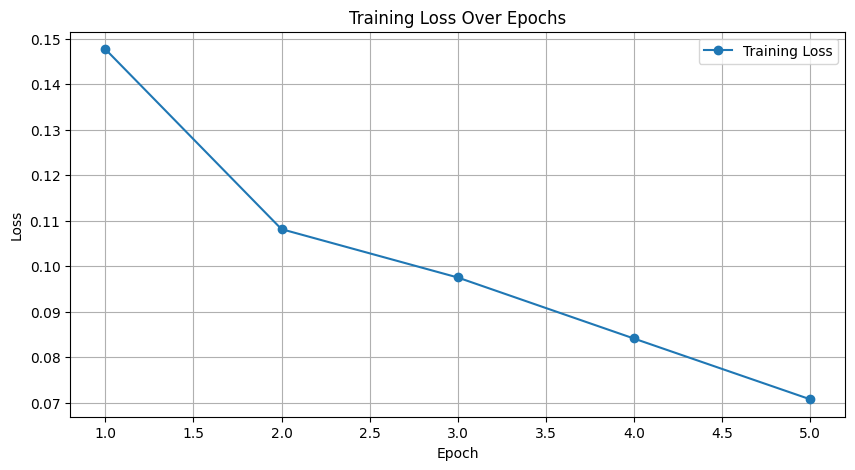

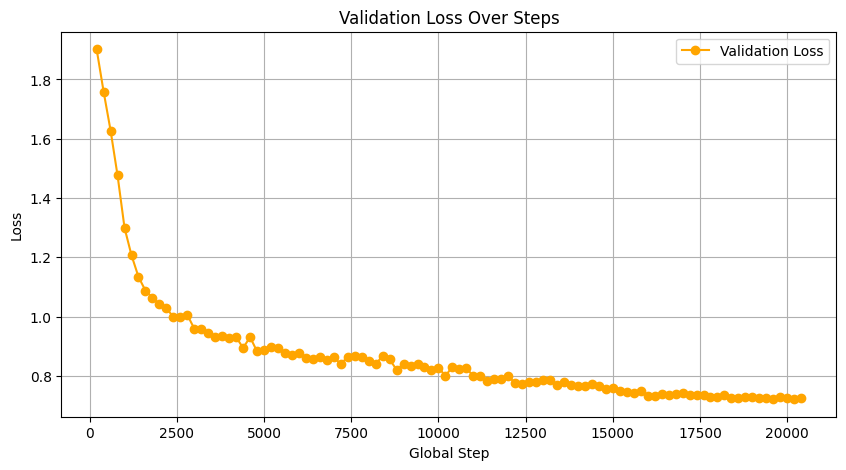

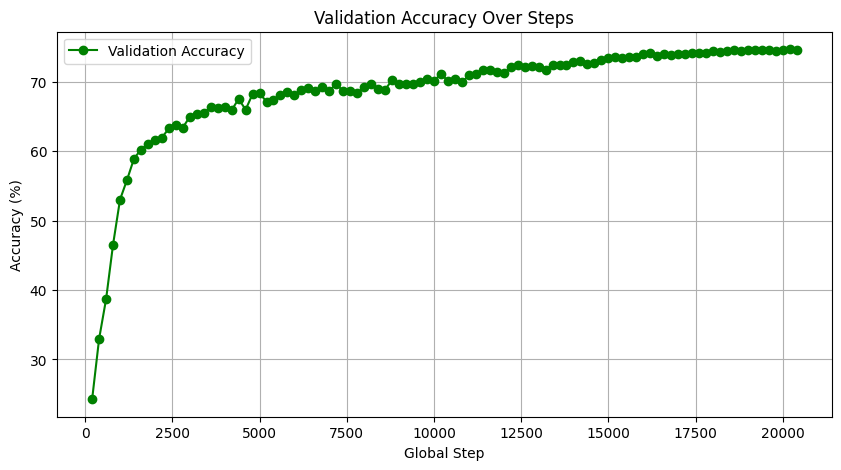

In [38]:
import matplotlib.pyplot as plt

# Plot Training Loss per Epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()
plt.show()

# Plot Validation Loss over Steps
plt.figure(figsize=(10, 5))
plt.plot(steps, valid_losses, marker='o', color='orange', label='Validation Loss')
plt.xlabel('Global Step')
plt.ylabel('Loss')
plt.title('Validation Loss Over Steps')
plt.grid(True)
plt.legend()
plt.show()

# Plot Validation Accuracy over Steps
plt.figure(figsize=(10, 5))
plt.plot(steps, valid_accuracies, marker='o', color='green', label='Validation Accuracy')
plt.xlabel('Global Step')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Steps')
plt.grid(True)
plt.legend()
plt.show()

In [39]:
# Evaluate on the test set and generate confusion matrix
model.eval()
test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    progress_bar = tqdm(test_loader, desc="Testing")
    for test_inputs, test_labels in progress_bar:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)

        # Calculate loss
        test_loss += criterion(test_outputs, test_labels).item()

        # Get predictions
        _, test_preds = torch.max(test_outputs, 1)

        # Track metrics
        total += test_labels.size(0)
        correct += (test_preds == test_labels).sum().item()

        # Collect predictions and labels for confusion matrix
        all_preds.extend(test_preds.cpu().numpy())
        all_labels.extend(test_labels.cpu().numpy())

# Final test metrics
final_test_accuracy = 100 * correct / total
final_test_loss = test_loss / len(test_loader)
print(f"Test Loss = {final_test_loss:.4f}, Test Accuracy = {final_test_accuracy:.2f}%")

Testing: 100%|██████████| 1062/1062 [01:25<00:00, 12.45it/s]

Test Loss = 0.7707, Test Accuracy = 72.55%


In [42]:
# Label mapping
class_names = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# Evaluate on the test set and generate confusion matrix
model.eval()
test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_labels = []
sample_images = []
sample_true_labels = []
sample_pred_labels = []

with torch.no_grad():
    progress_bar = tqdm(test_loader, desc="Testing")
    for test_inputs, test_labels in progress_bar:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)

        # Calculate loss
        test_loss += criterion(test_outputs, test_labels).item()

        # Get predictions
        _, test_preds = torch.max(test_outputs, 1)

        # Track metrics
        total += test_labels.size(0)
        correct += (test_preds == test_labels).sum().item()

        # Collect predictions and labels for confusion matrix
        all_preds.extend(test_preds.cpu().numpy())
        all_labels.extend(test_labels.cpu().numpy())

        # Save images, true labels, and predicted labels for visualization
        if len(sample_images) < 20:  # Collect 20 samples
            sample_images.extend(test_inputs.cpu().numpy())
            sample_true_labels.extend(test_labels.cpu().numpy())
            sample_pred_labels.extend(test_preds.cpu().numpy())

# Final test metrics
final_test_accuracy = 100 * correct / total
final_test_loss = test_loss / len(test_loader)
print(f"Test Loss = {final_test_loss:.4f}, Test Accuracy = {final_test_accuracy:.2f}%")

Testing: 100%|██████████| 1062/1062 [01:25<00:00, 12.44it/s]

Test Loss = 0.7707, Test Accuracy = 72.55%


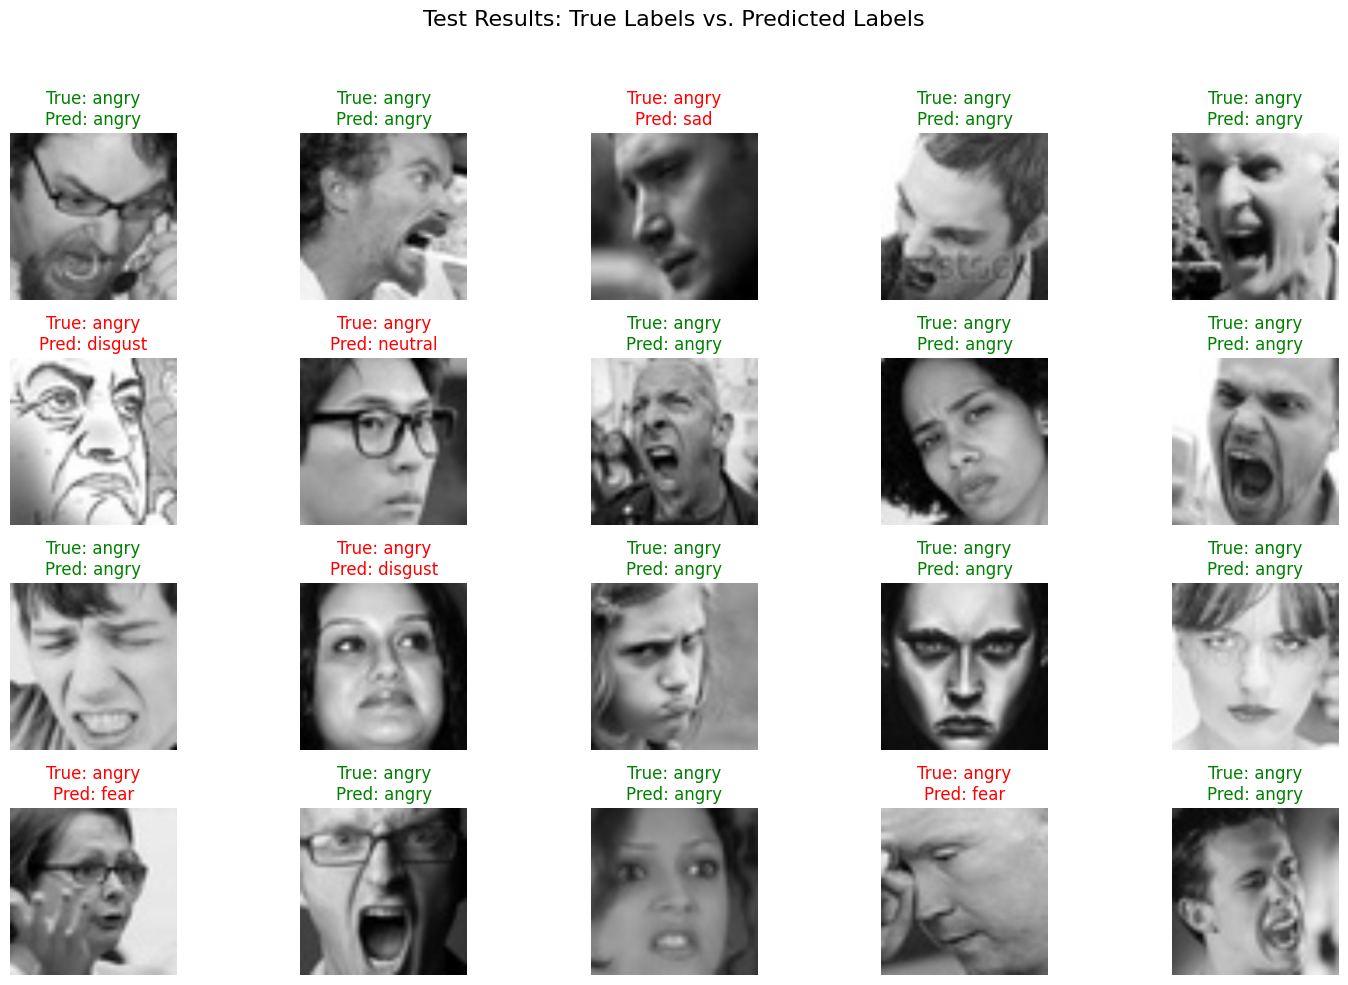

In [43]:
# Visualize 20 samples
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
fig.suptitle("Test Results: True Labels vs. Predicted Labels", fontsize=16)

for i, ax in enumerate(axes.flat):
    if i >= len(sample_images):
        break

    # Denormalize the image
    img = sample_images[i]
    img = img.transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    img = (img * 0.5 + 0.5) * 255  # Denormalize and scale back to [0, 255]
    img = np.clip(img, 0, 255).astype(np.uint8)  # Ensure valid pixel range

    # Display the image
    ax.imshow(img, cmap="gray" if img.shape[-1] == 1 else None)

    # Set the title with true and predicted labels
    true_label = class_names[sample_true_labels[i]]
    pred_label = class_names[sample_pred_labels[i]]
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=("green" if true_label == pred_label else "red"))
    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

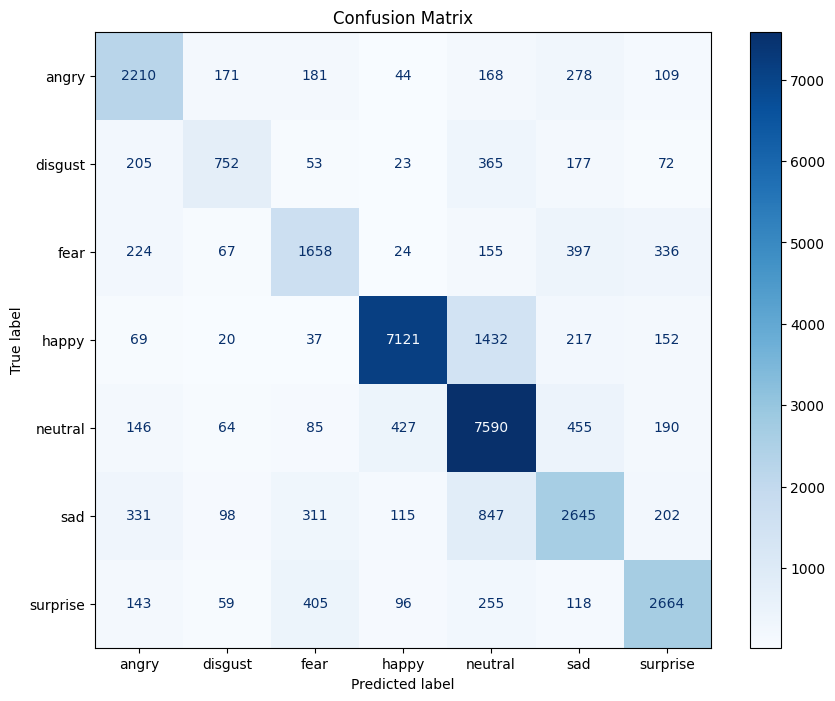

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix")
plt.show()

In [41]:
# Calculate class-wise accuracy
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)  # Per-class accuracy
class_names = classes  # Assuming `classes` is a list of class names
for class_name, accuracy in zip(class_names, class_accuracies):
    print(f"Accuracy for class '{class_name}': {accuracy * 100:.2f}%")

# Calculate overall average and weighted average accuracy
average_accuracy = np.mean(class_accuracies) * 100
weights = conf_matrix.sum(axis=1) / conf_matrix.sum()  # Class weights
weighted_average_accuracy = np.sum(class_accuracies * weights) * 100

print(f"Overall Average Accuracy: {average_accuracy:.2f}%")
print(f"Weighted Average Accuracy: {weighted_average_accuracy:.2f}%")

Accuracy for class 'angry': 69.91%
Accuracy for class 'disgust': 45.66%
Accuracy for class 'fear': 57.95%
Accuracy for class 'happy': 78.70%
Accuracy for class 'neutral': 84.74%
Accuracy for class 'sad': 58.14%
Accuracy for class 'surprise': 71.23%
Overall Average Accuracy: 66.62%
Weighted Average Accuracy: 72.55%


In [ ]:
# Function to preprocess and predict for a single image
def predict_image(image_path, model, class_names, transform, device):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")  # Convert to RGB
    image = transform(image).unsqueeze(0).to(device)  # Apply transforms and add batch dimension

    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(image)  # Forward pass
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)  # Convert to probabilities
        predicted_class_idx = probabilities.argmax().item()  # Get the index of the predicted class

    # Return the predicted class label and probabilities
    return class_names[predicted_class_idx], probabilities

# Define the preprocessing pipeline (same as during training)
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load the trained model
model_path = "trained_vit_model_1209.pth"
model = timm.create_model('vit_base_patch16_224', pretrained=False)
model.head = nn.Linear(model.head.in_features, len(classes))  # Ensure output matches the number of classes
model.load_state_dict(torch.load(model_path))
model = model.to(device)

<ipython-input-27-bd0f59bbc0fb>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


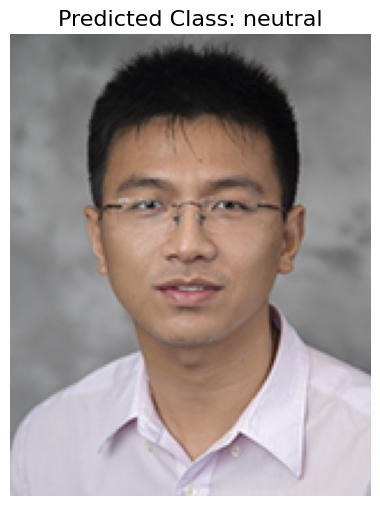

Probabilities:
angry: 0.0000
disgust: 0.0000
fear: 0.0000
happy: 0.0006
neutral: 0.9993
sad: 0.0000
surprise: 0.0001


In [ ]:
# Predict an uploaded image
uploaded_image_path = "/content/fs_jx77.jpg"
predicted_class, probabilities = predict_image(uploaded_image_path, model, classes, image_transform, device)

# Display the image
image = Image.open(uploaded_image_path)
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")
plt.title(f"Predicted Class: {predicted_class}", fontsize=16)
plt.show()

# Print the prediction
print("Probabilities:")
for i, prob in enumerate(probabilities):
    print(f"{classes[i]}: {prob:.4f}")

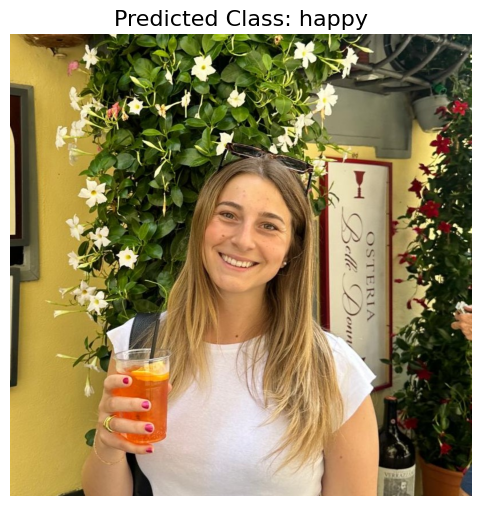

Probabilities:
angry: 0.0000
disgust: 0.0003
fear: 0.0000
happy: 0.8925
neutral: 0.1038
sad: 0.0000
surprise: 0.0035


In [ ]:
# Predict an uploaded image
uploaded_image_path = "/content/Caterina.jpg"
predicted_class, probabilities = predict_image(uploaded_image_path, model, classes, image_transform, device)

# Display the image
image = Image.open(uploaded_image_path)
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")
plt.title(f"Predicted Class: {predicted_class}", fontsize=16)
plt.show()

# Print the prediction
print("Probabilities:")
for i, prob in enumerate(probabilities):
    print(f"{classes[i]}: {prob:.4f}")